# This notebook is for calculating mineral indices using Landsat 8 data

In [1]:
%pylab notebook
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube.storage.storage import write_dataset_to_netcdf

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

In [3]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Define temporal range
start_of_epoch = '2013-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'swir2'
                     ]
sensors = ['ls8'], #May 2013 to present 
query = {'time': (start_of_epoch, end_of_epoch),}


lat_max = -15.2
lat_min = -15.5
lon_max = 128.3
lon_min = 128.6  
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [5]:
print (query)

{'time': ('2013-01-01', '2016-12-31'), 'y': (-15.2, -15.5), 'x': (128.6, 128.3), 'crs': 'EPSG:4326'}


## PQ and Index preparation


In [10]:
##This may have been superseded 
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name('ls8_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [11]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [14]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    sensor_nbar = dc.load(product= 'ls8_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= 'ls8_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)


TypeError: unhashable type: 'list'

In [15]:
sensor_nbar

<xarray.Dataset>
Dimensions:  (time: 78, x: 1336, y: 1355)
Coordinates:
  * time     (time) datetime64[ns] 2013-04-26T01:31:31 ...
  * y        (y) float64 -1.618e+06 -1.618e+06 -1.618e+06 -1.618e+06 ...
  * x        (x) float64 -4.007e+05 -4.007e+05 -4.007e+05 -4.007e+05 ...
Data variables:
    blue     (time, y, x) float64 509.0 535.0 511.0 481.0 474.0 506.0 523.0 ...
    green    (time, y, x) float64 709.0 730.0 700.0 652.0 665.0 707.0 711.0 ...
    red      (time, y, x) float64 920.0 952.0 907.0 862.0 870.0 921.0 935.0 ...
    nir      (time, y, x) float64 1.28e+03 1.299e+03 1.265e+03 1.22e+03 ...
    swir1    (time, y, x) float64 822.0 900.0 891.0 794.0 821.0 843.0 803.0 ...
    swir2    (time, y, x) float64 374.0 464.0 445.0 367.0 367.0 399.0 394.0 ...
Attributes:
    crs: EPSG:3577

In [29]:
#Calculate annual average NDVI values
#but you'll need to update the code below here accordingly
annual_mean_iron_oxide_ratio = annual_iron_oxide_ratio.median(dim = 'time')

## Plotting the iron oxide ratio

<IPython.core.display.Javascript object>


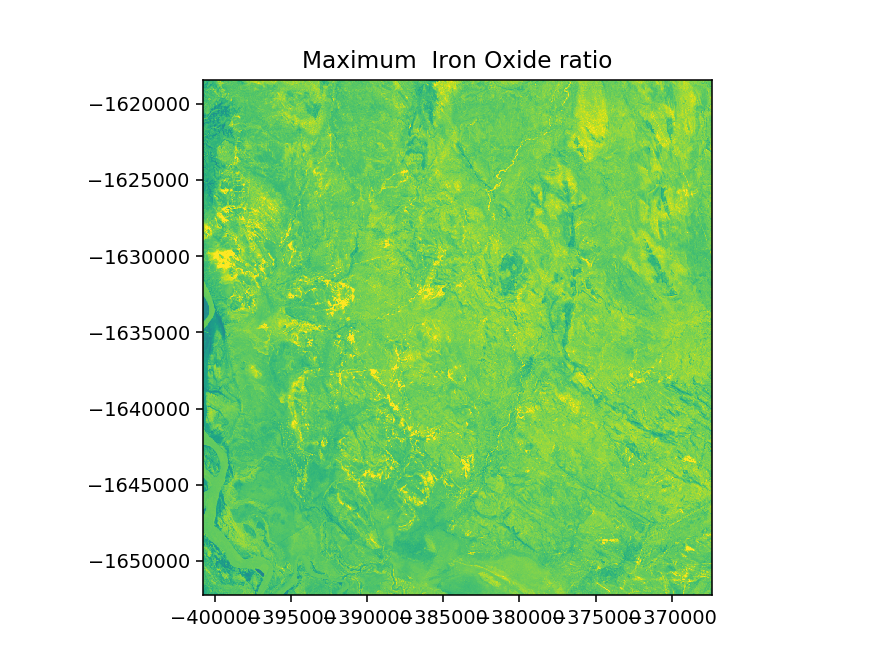

In [42]:
iron_oxide_ratio = sensor_nbar.red/sensor_nbar.blue
iron_oxide_ratio_stats = iron_oxide_ratio.max(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
plt.title('Maximum  Iron Oxide ratio')
plt.imshow(iron_oxide_ratio_stats, vmin = 0, vmax = 3,
           extent=[arr_yoi.coords['x'].min(), arr_yoi.coords['x'].max(), 
                   arr_yoi.coords['y'].min(), arr_yoi.coords['y'].max()])

## Plotting the ferrous iron ratio

<IPython.core.display.Javascript object>


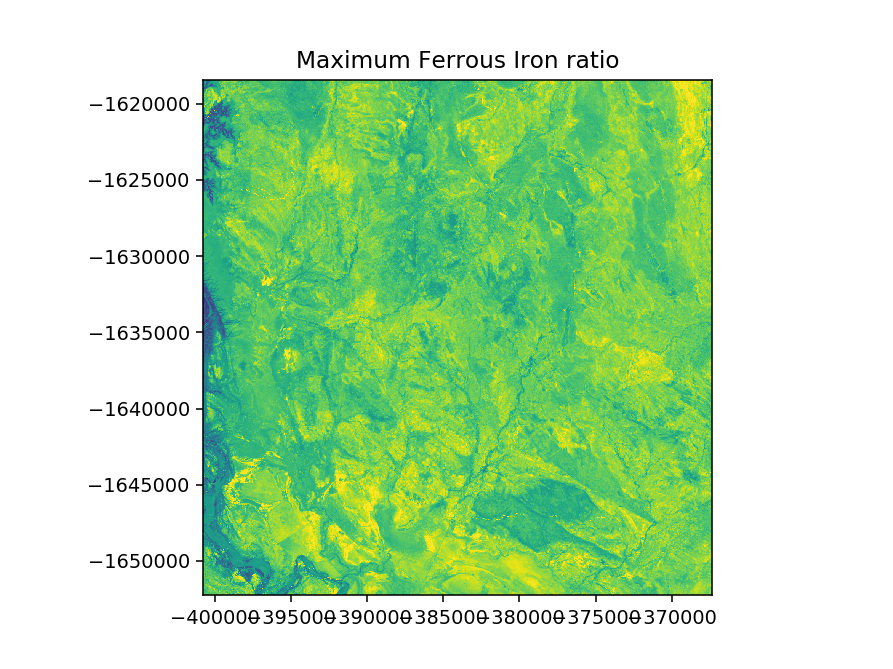

In [43]:
ferrous_iron = sensor_nbar.swir1/sensor_nbar.nir
ferrous_iron_stats = ferrous_iron.max(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
plt.title('Maximum Ferrous Iron ratio')
plt.imshow(ferrous_iron_stats, vmin = 0, vmax  = 2,
           extent=[arr_yoi.coords['x'].min(), arr_yoi.coords['x'].max(), 
                   arr_yoi.coords['y'].min(), arr_yoi.coords['y'].max()])

## Plotting the Clay NIR/SWIR ratio

<IPython.core.display.Javascript object>


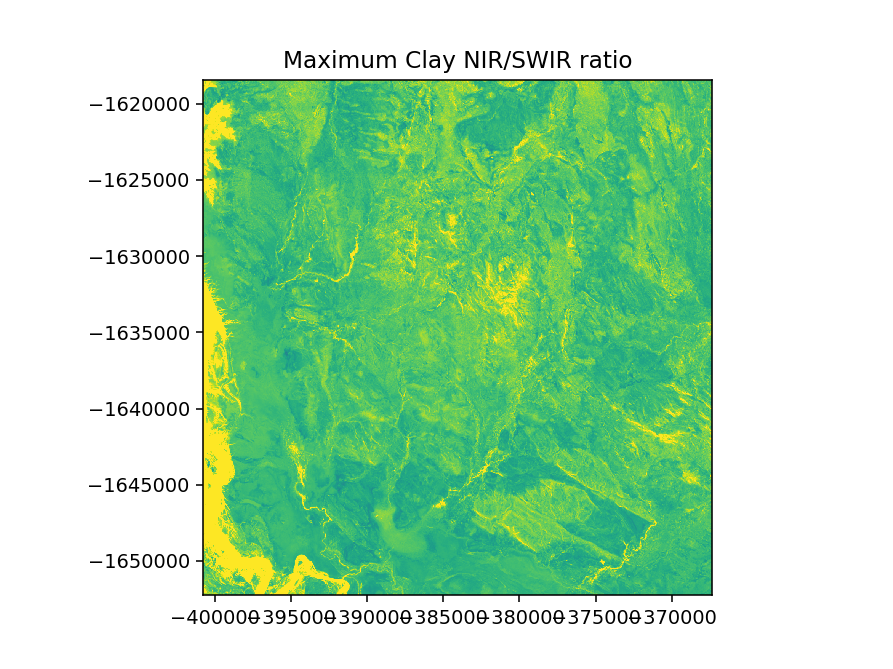

In [48]:
clay_nirswir = sensor_nbar.nir/sensor_nbar.swir1
clay_nirswir_stats = clay_nirswir.median(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
plt.title('Maximum Clay NIR/SWIR ratio')
plt.imshow(clay_nirswir_stats, vmin = 0, vmax = 1.2,
           extent=[arr_yoi.coords['x'].min(), arr_yoi.coords['x'].max(), 
                   arr_yoi.coords['y'].min(), arr_yoi.coords['y'].max()])

## Plotting the Clay SWIR1/SWIR2 ratio

<IPython.core.display.Javascript object>


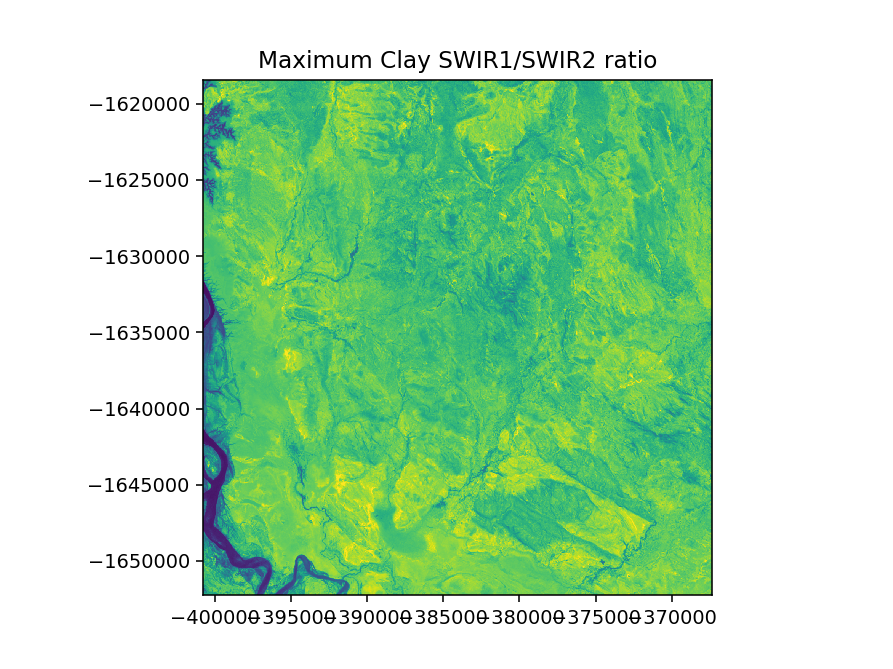

In [52]:
clay_swir1_swir2 = sensor_nbar.swir1/sensor_nbar.nir
clay_swir1_swir2_stats = clay_swir1_swir2.median(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
plt.title('Maximum Clay SWIR1/SWIR2 ratio')
plt.imshow(clay_swir1_swir2_stats, vmin = 0, vmax = 1.6,
           extent=[arr_yoi.coords['x'].min(), arr_yoi.coords['x'].max(), 
                   arr_yoi.coords['y'].min(), arr_yoi.coords['y'].max()])

## Plotting the ferruginous regolith ratio

<IPython.core.display.Javascript object>


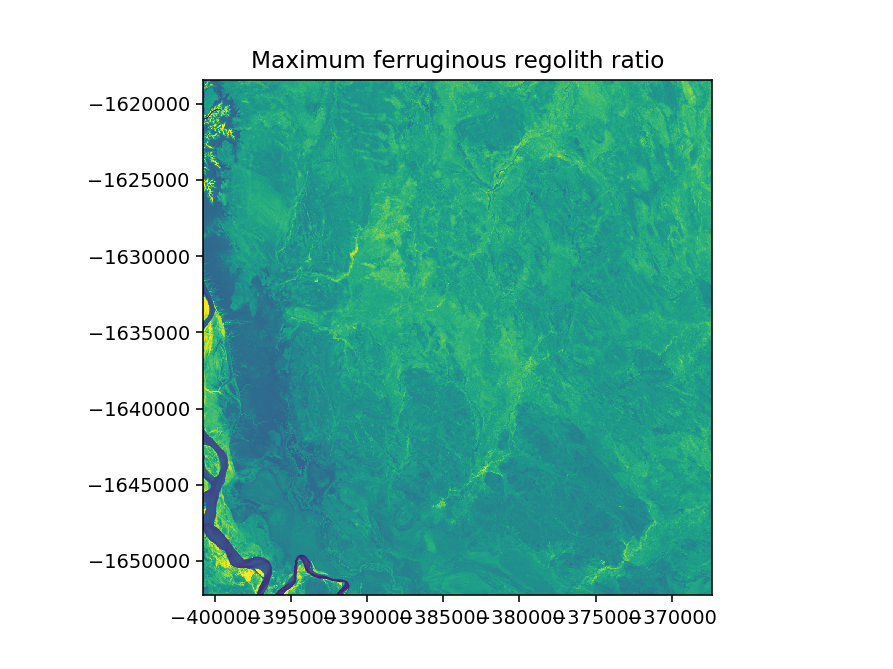

In [55]:
ferruginous_reg = sensor_nbar.nir/sensor_nbar.green
ferruginous_reg_stats = ferruginous_reg.median(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
plt.title('Maximum ferruginous regolith ratio')
plt.imshow(ferruginous_reg_stats, vmin = 0, vmax = 5,
           extent=[arr_yoi.coords['x'].min(), arr_yoi.coords['x'].max(), 
                   arr_yoi.coords['y'].min(), arr_yoi.coords['y'].max()])